# Hierarchical Classification


There are essentially two types of hierachical:

In [65]:
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 20, 9

In [66]:
from IPython.display import Image

One is to ignore all taxomy information, and do a single multi class classification.
Otherwise

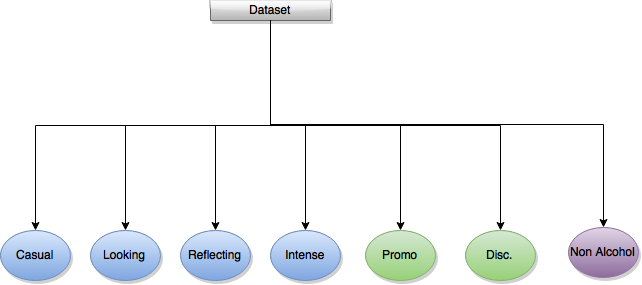

In [67]:
Image(filename='./assets/Classification_flat.png')

Is the other method is to train a classifier in each branch. So there we will need to build and train 3 different classifiers. 

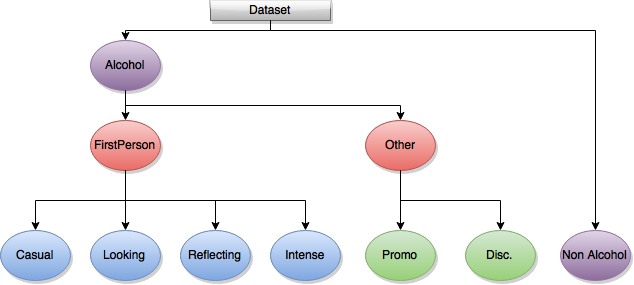

In [68]:
Image(filename='./assets/Classification.png') 

We will focus on building a simple heirarchical model based on on this branching.

1. We will first build three classifiers and evaluate the error independently.
2. Then we will take a look at the error propogation.

In [5]:
from dao import DataAccess, LabelGetter

In [6]:
XX = DataAccess.get_as_dataframe()
XX.head()

,created_at,labels,predict,text,user
_id,,,,,
556e0ee3d6dfbb462880f0a5,Tue Jun 02 20:16:08 +0000 2015,{'alcohol': 0},0.526050,Impatiently waiting to get our hands on the ne...,{'created_at': 'Thu Jun 12 22:14:05 +0000 2014...
556e128ad6dfbb46288111e4,Tue Jun 02 20:31:44 +0000 2015,"{'alcohol_related': 1, 'raw': 'Alcohol Related...",0.516649,Beer fans need their @ColumbusBrewing Bodhi. I...,{'created_at': 'Mon Oct 06 21:00:38 +0000 2008...
556e1464d6dfbb4628812330,Tue Jun 02 20:39:37 +0000 2015,{'alcohol': 1},0.502633,Stone Cold use to be the baddest MF in my book...,{'created_at': 'Sun Mar 11 08:22:56 +0000 2012...
556e15f1d6dfbb4628813236,Tue Jun 02 20:46:14 +0000 2015,{'alcohol': 1},0.535758,Now @iamjohnoliver has to drink a Bud Light Li...,{'created_at': 'Thu Jan 14 03:03:33 +0000 2010...
556e1adcd6dfbb50e34a1ed6,Tue Jun 02 21:07:13 +0000 2015,{'alcohol': 0},0.533892,I'm ready for a yard sale and to sell all the...,{'created_at': 'Sun Oct 24 23:02:03 +0000 2010...


# GridSearch for RandomForests and Logisitic Regression

Here I'll be doing a quick grid search just to get a rough idea as to how the params could look for  semi-optimal params

In [48]:
import pylab as plt
import pandas as pd

from pprint import pprint

from scipy.stats import uniform, randint

from pipelines.alcohol import AlcoholPipeline

from sklearn.grid_search import RandomizedSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [8]:
def n_grams(start, end):
    for a in range(1, start+1):
        for b in range(1, end+1):
                if a < b:
                    yield (a, b)

Split Data and Train

In [9]:
data = LabelGetter(XX)
X, y = data.get_alcohol()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

### Logistic Regression

### Logistic Regression Summary
 
 -----
**params**
```
{'clf__C': 79.75564168451815,
 'features__text__tfidf__analyzer': 'char',
 'features__text__tfidf__lowercase': True,
 'features__text__tfidf__max_features': 93000,
 'features__text__tfidf__ngram_range': (1, 5),
 'features__text__tfidf__norm': 'l2'}
```

**f1_score**
```
0.84205429626895389
```

In [10]:
clf = AlcoholPipeline(global_features=["text"]).pipeline(LogisticRegression())#.set_params(**params)

In [11]:
params = {
'clf__C': uniform(0.01, 1000),
'features__text__tfidf__analyzer':['word', 'char'],
'features__text__tfidf__lowercase': [False, True],
'features__text__tfidf__max_features': list(range(10000, 100000, 1000)),
'features__text__tfidf__ngram_range': list(n_grams(3, 14)),
'features__text__tfidf__norm': ['l2']
}

In [12]:
lr_clf_rgs = RandomizedSearchCV(clf, params, n_iter=60, n_jobs=4, verbose=1, scoring="f1")
lr_clf_rgs.fit(X_train, y_train)

### Random Forest Summary
------
 
**params**
```
{'clf__class_weight': 'auto',
 'clf__max_depth': 110,
 'clf__max_features': 4000,
 'clf__n_estimators': 500,
 'features__text__tfidf__analyzer': 'char',
 'features__text__tfidf__max_features': 90000,
 'features__text__tfidf__ngram_range': (1, 3)}
```

**f1_score**
```
0.86430449935303511 
```

In [27]:
clf = AlcoholPipeline(global_features=["text"]).pipeline(RandomForestClassifier(
        n_jobs=4,
    ))

In [87]:
tree_params = {
    'clf__class_weight': ["auto"],
    'clf__max_depth': list(range(10, 400, 50)),
    'clf__max_features': [4000, 10000, 20000],
    'clf__n_estimators': [50, 100, 500],
    'features__text__tfidf__analyzer':['char'],
    'features__text__tfidf__max_features': [90000],
    'features__text__tfidf__ngram_range':[(1,3)],
}

In [29]:
rf_clf_rgs = RandomizedSearchCV(clf, params, n_iter=6, n_jobs=1, verbose=3, scoring="f1")
rf_clf_rgs.fit(X_train, y_train)

# GridSearch for Hierarchies 

In [99]:
params = {'clf__C': 79.75564168451815,
 'features__text__tfidf__analyzer': 'char',
 'features__text__tfidf__lowercase': True,
 'features__text__tfidf__max_features': 93000,
 'features__text__tfidf__ngram_range': (1, 5),
 'features__text__tfidf__norm': 'l2'}

params = {
'clf__C': uniform(0.01, 1000),
'features__text__tfidf__analyzer':['word', 'char'],
'features__text__tfidf__lowercase': [False, True],
'features__text__tfidf__max_features': list(range(10000, 100000, 1000)),
'features__text__tfidf__ngram_range': list(n_grams(3, 14)),
'features__text__tfidf__norm': ['l2']
}

In [115]:
from pipelines.helpers import ExplodingRecordJoiner

XX = ExplodingRecordJoiner(user=[
                'created_at',
                'favourites_count',
                'followers_count',
                'friends_count',
                'statuses_count',
                'verified'
            ]).fit_transform(XX)

In [117]:
def evaluate(clf, label):
    X, y = LabelGetter(XX)._get_labels(label)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=42)
    clf.fit(X_train, y_train)
    y_predict = clf.predict(X_test)
    results = {
        "accuracy": metrics.accuracy_score(y_test, y_predict),
        "f1_score": metrics.f1_score(y_test, y_predict)
    }
    print(metrics.classification_report(y_test, y_predict))
    print(metrics.confusion_matrix(y_test, y_predict))
    print("accuracy", metrics.accuracy_score(y_test, y_predict))

### Alcohol

In [103]:
clf = AlcoholPipeline(global_features=["text"]).pipeline(LogisticRegression()) #.set_params(**params)
lr_clf_rgs = RandomizedSearchCV(clf, params, n_iter=100, n_jobs=4, verbose=1, scoring="f1")
evaluate(lr_clf_rgs, "alcohol")

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=4)]: Done   1 jobs       | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  50 jobs       | elapsed:   39.2s
[Parallel(n_jobs=4)]: Done 200 jobs       | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 294 out of 300 | elapsed:  3.3min remaining:    4.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:  3.4min finished


             precision    recall  f1-score   support

          0       0.85      0.55      0.67       538
          1       0.76      0.94      0.84       837

avg / total       0.80      0.79      0.77      1375

[[297 241]
 [ 54 783]]
accuracy 0.785454545455


### First Person 

In [104]:
clf = AlcoholPipeline(global_features=["text"]).pipeline(LogisticRegression()) #.set_params(**params)
lr_clf_rgs = RandomizedSearchCV(clf, params, n_iter=100, n_jobs=4, verbose=1, scoring="f1")
evaluate(lr_clf_rgs, "first_person")

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=4)]: Done   1 jobs       | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  50 jobs       | elapsed:    6.0s
[Parallel(n_jobs=4)]: Done 200 jobs       | elapsed:   42.5s
[Parallel(n_jobs=4)]: Done 294 out of 300 | elapsed:  1.1min remaining:    1.4s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:  1.1min finished


             precision    recall  f1-score   support

          0       0.65      0.08      0.14       168
          1       0.58      0.97      0.72       219

avg / total       0.61      0.58      0.47       387

[[ 13 155]
 [  7 212]]
accuracy 0.581395348837


In [123]:
clf = AlcoholPipeline(global_features=["text", "user"]).pipeline(LogisticRegression()) #.set_params(**params)
lr_clf_rgs = RandomizedSearchCV(clf, params, n_iter=100, n_jobs=4, verbose=1, scoring="f1")
evaluate(lr_clf_rgs, "first_person")

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=4)]: Done   1 jobs       | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done  50 jobs       | elapsed:   17.6s
[Parallel(n_jobs=4)]: Done 200 jobs       | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:  1.6min finished


             precision    recall  f1-score   support

          0       0.66      0.45      0.54       168
          1       0.66      0.82      0.73       219

avg / total       0.66      0.66      0.65       387

[[ 76  92]
 [ 40 179]]
accuracy 0.658914728682


In [124]:
clf = AlcoholPipeline(global_features=["text", "time"]).pipeline(LogisticRegression()) #.set_params(**params)
lr_clf_rgs = RandomizedSearchCV(clf, params, n_iter=100, n_jobs=4, verbose=1, scoring="f1")
evaluate(lr_clf_rgs, "first_person")

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=4)]: Done   1 jobs       | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done  50 jobs       | elapsed:   13.7s
[Parallel(n_jobs=4)]: Done 200 jobs       | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:  1.8min finished


             precision    recall  f1-score   support

          0       0.55      0.57      0.56       168
          1       0.66      0.64      0.65       219

avg / total       0.61      0.61      0.61       387

[[ 95  73]
 [ 78 141]]
accuracy 0.609819121447


In [128]:
clf = AlcoholPipeline(global_features=["text", "time", "user"]).pipeline(LogisticRegression()) #.set_params(**params)
lr_clf_rgs = RandomizedSearchCV(clf, params, n_iter=100, n_jobs=4, verbose=1, scoring="f1")
evaluate(lr_clf_rgs, "first_person")

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=4)]: Done   1 jobs       | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  50 jobs       | elapsed:   18.2s
[Parallel(n_jobs=4)]: Done 200 jobs       | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 294 out of 300 | elapsed:  1.9min remaining:    2.3s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:  1.9min finished


             precision    recall  f1-score   support

          0       0.55      0.43      0.49       168
          1       0.63      0.73      0.68       219

avg / total       0.60      0.60      0.59       387

[[ 73  95]
 [ 59 160]]
accuracy 0.602067183463


### First Person Levels

In [129]:
clf = AlcoholPipeline(global_features=["text"]).pipeline(LogisticRegression()) #.set_params(**params)
lr_clf_rgs = RandomizedSearchCV(clf, params, n_iter=100, n_jobs=4, verbose=1, scoring="accuracy")
evaluate(lr_clf_rgs, "first_person_level")

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=4)]: Done   1 jobs       | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  50 jobs       | elapsed:    7.4s
[Parallel(n_jobs=4)]: Done 200 jobs       | elapsed:   33.0s
[Parallel(n_jobs=4)]: Done 294 out of 300 | elapsed:   47.8s remaining:    1.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   49.5s finished


             precision    recall  f1-score   support

          0       0.47      0.41      0.44        58
          1       0.50      0.58      0.54        83
          2       0.39      0.48      0.43        50
          3       0.45      0.18      0.26        28

avg / total       0.46      0.46      0.45       219

[[24 20 13  1]
 [18 48 16  1]
 [ 7 15 24  4]
 [ 2 13  8  5]]
accuracy 0.461187214612


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


In [130]:
clf = AlcoholPipeline(global_features=["text", "user"]).pipeline(LogisticRegression()) #.set_params(**params)
lr_clf_rgs = RandomizedSearchCV(clf, params, n_iter=100, n_jobs=4, verbose=1, scoring="accuracy")
evaluate(lr_clf_rgs, "first_person_level")

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=4)]: Done   1 jobs       | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done  50 jobs       | elapsed:   21.4s
[Parallel(n_jobs=4)]: Done 200 jobs       | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 294 out of 300 | elapsed:  1.8min remaining:    2.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:  1.8min finished


             precision    recall  f1-score   support

          0       0.47      0.40      0.43        58
          1       0.51      0.57      0.53        83
          2       0.39      0.54      0.45        50
          3       0.43      0.11      0.17        28

avg / total       0.46      0.46      0.44       219

[[23 19 15  1]
 [18 47 17  1]
 [ 6 15 27  2]
 [ 2 12 11  3]]
accuracy 0.456621004566


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


In [131]:
clf = AlcoholPipeline(global_features=["text", "time"]).pipeline(LogisticRegression()) #.set_params(**params)
lr_clf_rgs = RandomizedSearchCV(clf, params, n_iter=100, n_jobs=4, verbose=1, scoring="accuracy")
evaluate(lr_clf_rgs, "first_person_level")

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=4)]: Done   1 jobs       | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done  50 jobs       | elapsed:   10.6s
[Parallel(n_jobs=4)]: Done 200 jobs       | elapsed:   42.4s
[Parallel(n_jobs=4)]: Done 294 out of 300 | elapsed:  1.0min remaining:    1.3s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:  1.1min finished


             precision    recall  f1-score   support

          0       0.49      0.40      0.44        58
          1       0.43      0.51      0.47        83
          2       0.23      0.30      0.26        50
          3       0.09      0.04      0.05        28

avg / total       0.36      0.37      0.36       219

[[23 19 14  2]
 [14 42 23  4]
 [ 6 25 15  4]
 [ 4 11 12  1]]
accuracy 0.369863013699


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
